In [1]:
import os
import numpy as np

from keras.preprocessing import sequence
import keras.models as km
import keras.layers as kl
import keras.constraints as kc
from keras.datasets import imdb
from keras import losses

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as ipw

import data_preparation as mdp
from mercari_config import MercariConfig

Using TensorFlow backend.


In [2]:
num_words_item_desc = MercariConfig.MAX_WORDS_FROM_INDEX_4_ITEM_DESC + MercariConfig.WORD_I
max_seq_len_item_desc = MercariConfig.MAX_WORDS_IN_ITEM_DESC + 1 # Remember: first word is always <START>
embedding_dims = 64

num_words_name = MercariConfig.MAX_WORDS_FROM_INDEX_4_NAME + MercariConfig.WORD_I
max_seq_len_name = MercariConfig.MAX_WORDS_IN_NAME + 1 # Remember: first word is always <START>

batch_size = 200

In [3]:
%%time

train_data = mdp.load_data(MercariConfig.TRAINING_SET_PREP_FILE)
X_item_desc_seq_train = train_data[['id' + str(i) for i in range(max_seq_len_item_desc)]].as_matrix()
X_name_seq_train = train_data[['nm' + str(i) for i in range(max_seq_len_name)]].as_matrix()
x_cat_train = train_data['category_id'].as_matrix()
x_brand_train = train_data['brand_id'].as_matrix()
x_f_train = train_data[['item_condition_id', 'shipping']].as_matrix()
y_train = train_data['price'].as_matrix()

CPU times: user 17.6 s, sys: 1.81 s, total: 19.4 s
Wall time: 22.7 s


In [4]:
print(X_item_desc_seq_train.shape, X_name_seq_train.shape, 
      x_cat_train.shape, x_brand_train.shape, x_f_train.shape, y_train.shape)

(237205, 501) (237205, 21) (237205,) (237205,) (237205, 2) (237205,)


In [5]:
%%time

val_data = mdp.load_data(MercariConfig.VALIDATION_SET_PREP_FILE)
X_item_desc_seq_val = val_data[['id' + str(i) for i in range(max_seq_len_item_desc)]].as_matrix()
X_name_seq_val = val_data[['nm' + str(i) for i in range(max_seq_len_name)]].as_matrix()
x_cat_val = val_data['category_id'].as_matrix()
x_brand_val = val_data['brand_id'].as_matrix()
x_f_val = val_data[['item_condition_id', 'shipping']].as_matrix()
y_val = val_data['price'].as_matrix()

CPU times: user 4.41 s, sys: 152 ms, total: 4.56 s
Wall time: 5.14 s


In [6]:
print(X_item_desc_seq_val.shape, X_name_seq_val.shape, 
      x_cat_val.shape, x_brand_val.shape, x_f_val.shape, y_val.shape)

(59302, 501) (59302, 21) (59302,) (59302,) (59302, 2) (59302,)


In [7]:
%%time

X_item_desc_seq_train = sequence.pad_sequences(
    X_item_desc_seq_train, maxlen=max_seq_len_item_desc, padding='post', truncating='post')
X_name_seq_train = sequence.pad_sequences(
    X_name_seq_train, maxlen=max_seq_len_name, padding='post', truncating='post')

X_item_desc_seq_val = sequence.pad_sequences(
    X_item_desc_seq_val, maxlen=max_seq_len_item_desc, padding='post', truncating='post')
X_name_seq_val = sequence.pad_sequences(
    X_name_seq_val, maxlen=max_seq_len_name, padding='post', truncating='post')

CPU times: user 6.1 s, sys: 452 ms, total: 6.55 s
Wall time: 6.91 s


In [8]:
feature_input = kl.Input(shape=(2,), name='feature_input')
category_input = kl.Input(shape=(1,), name='category_input')
brand_input = kl.Input(shape=(1,), name='brand_input')
item_desc_input = kl.Input(shape=(max_seq_len_item_desc,), name='item_desc_input')
name_input = kl.Input(shape=(max_seq_len_name,), name='name_input')

item_desc_embedding = kl.Embedding(num_words_item_desc, embedding_dims, name='item_desc_embedding')
item_desc_embedding_dropout = kl.SpatialDropout1D(0.5, name='item_desc_embedding_dropout')
item_desc_lstm_1 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_1', return_sequences=True)
item_desc_lstm_2 = kl.CuDNNLSTM(units=200, name='item_desc_lstm_2')
item_desc_lstm_dropout = kl.Dropout(0.5, name='item_desc_lstm_dropout')

name_embedding = kl.Embedding(num_words_name, embedding_dims, name='name_embedding')
name_embedding_dropout = kl.SpatialDropout1D(0.5, name='name_embedding_dropout')
name_lstm_1 = kl.CuDNNLSTM(units=200, name='name_lstm_1', return_sequences=True)
name_lstm_2 = kl.CuDNNLSTM(units=200, name='name_lstm_2')
name_lstm_dropout = kl.Dropout(0.5, name='name_lstm_dropout')

category_embedding = kl.Embedding(1105, 32, name='category_embedding')
category_reshape = kl.Reshape(target_shape=(32,), name='category_reshape')

brand_embedding = kl.Embedding(2774, 32, name='brand_embedding')
brand_reshape = kl.Reshape(target_shape=(32,), name='brand_reshape')

input_fusion = kl.Concatenate(axis=1, name='input_fusion')
fusion_dense_1 = kl.Dense(400, activation='relu', name='fusion_dense_1')
fusion_dense_2 = kl.Dense(200, activation='relu', name='fusion_dense_2')
fusion_dense_3 = kl.Dense(1, activation='relu', name='fusion_dense_3')

item_desc_output = item_desc_embedding(item_desc_input)
item_desc_output = item_desc_embedding_dropout(item_desc_output)
item_desc_output = item_desc_lstm_1(item_desc_output)
item_desc_output = item_desc_lstm_2(item_desc_output)
item_desc_output = item_desc_lstm_dropout(item_desc_output)

name_output = name_embedding(name_input)
name_output = name_embedding_dropout(name_output)
name_output = name_lstm_1(name_output)
name_output = name_lstm_2(name_output)
name_output = name_lstm_dropout(name_output)

category_output = category_embedding(category_input)
category_output = category_reshape(category_output)

brand_output = brand_embedding(brand_input)
brand_output = brand_reshape(brand_output)

output = input_fusion([name_output, item_desc_output, category_output, brand_output, feature_input])
output = fusion_dense_1(output)
output = fusion_dense_2(output)
prediction = fusion_dense_3(output)

model = km.Model(inputs=[feature_input, category_input, brand_input, name_input, item_desc_input], outputs=prediction)

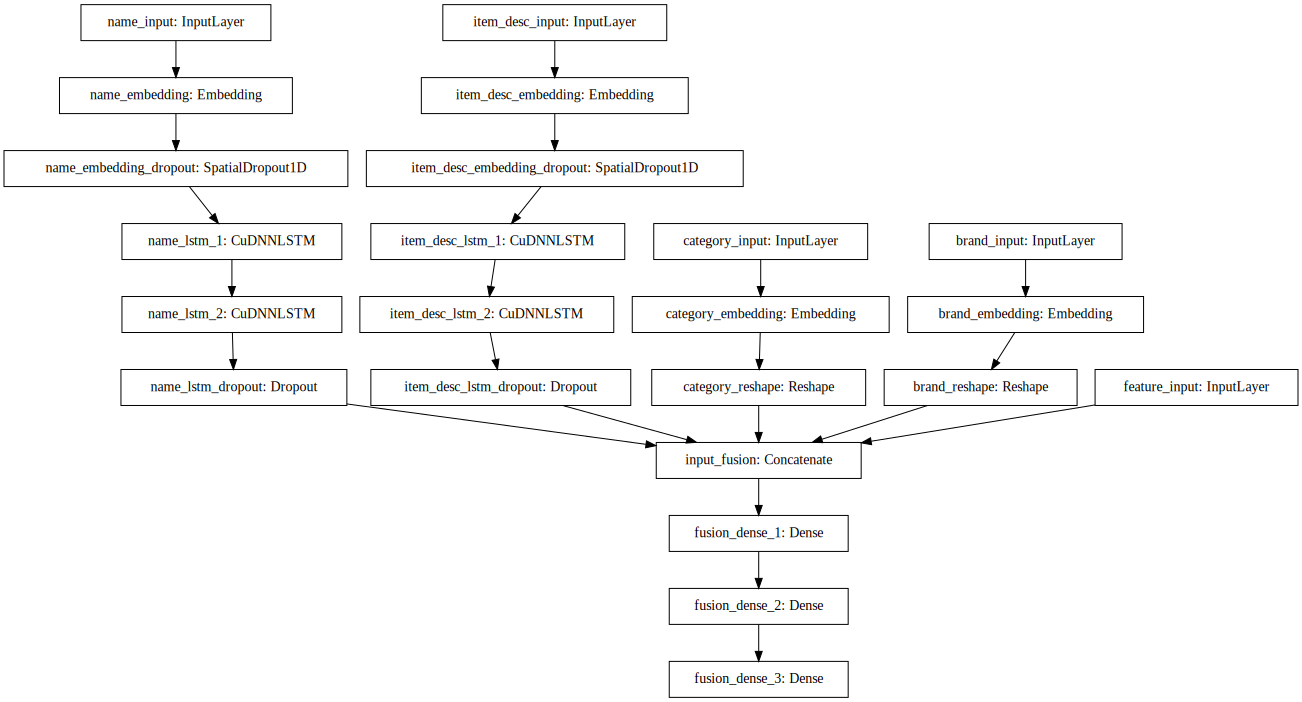

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name_input (InputLayer)         (None, 21)           0                                            
__________________________________________________________________________________________________
item_desc_input (InputLayer)    (None, 501)          0                                            
__________________________________________________________________________________________________
name_embedding (Embedding)      (None, 21, 64)       1984512     name_input[0][0]                 
__________________________________________________________________________________________________
item_desc_embedding (Embedding) (None, 501, 64)      2560512     item_desc_input[0][0]            
__________________________________________________________________________________________________
name_embed

In [11]:
from keras import backend as K
import keras

def root_mean_squared_logarithmic_error(y_true, y_pred):
    ret = losses.mean_squared_logarithmic_error(y_true, y_pred)
    return K.sqrt(ret)

def root_mean_squared_error(y_true, y_pred):
    ret = losses.mean_squared_error(y_true, y_pred)
    return K.sqrt(ret)

In [12]:
model.compile(optimizer='adam', loss=root_mean_squared_error, metrics=[root_mean_squared_logarithmic_error])

In [10]:
from keras.models import load_model

model = load_model(os.path.join(MercariConfig.MODEL_DIR, 'my_modelv2 - 3 times 10 ep.h5'), 
                   custom_objects={'root_mean_squared_error': root_mean_squared_error, 
                                   'root_mean_squared_logarithmic_error': root_mean_squared_logarithmic_error})

In [17]:
tf_log_dir = MercariConfig.get_new_tf_log_dir()
tb_callback = keras.callbacks.TensorBoard(log_dir=tf_log_dir, histogram_freq=0, batch_size=batch_size, 
                            write_graph=True, write_grads=False, write_images=False, 
                            embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

history_simple = model.fit(
    [x_f_train, x_cat_train, x_brand_train, X_name_seq_train, X_item_desc_seq_train], y_train,
    batch_size=batch_size,
    epochs=12,
    verbose=1,
    callbacks=[tb_callback],
    shuffle=True,
    initial_epoch=11,
    validation_data=[[x_f_val, x_cat_val, x_brand_val, X_name_seq_val, X_item_desc_seq_val], y_val])

Train on 237205 samples, validate on 59302 samples
Epoch 12/12
237205/237205 [==============================] - 639s 3ms/step - loss: 11.9396 - root_mean_squared_logarithmic_error: 0.4073 - val_loss: 12.1274 - val_root_mean_squared_logarithmic_error: 0.4130


In [15]:
model.save(os.path.join(MercariConfig.MODEL_DIR, 'my_model.h5'))

In [12]:
model.evaluate(x=[x_f_val, x_cat_val, x_brand_val, X_name_seq_val, X_item_desc_seq_val], y=y_val, 
               batch_size=batch_size, verbose=1, sample_weight=None, steps=None)

59302/59302 [==============================] - 48s 809us/step


[12.03525314097549, 0.40940269557067843]

In [14]:
y_pred = model.predict(x=[x_f_val, x_cat_val, x_brand_val, X_name_seq_val, X_item_desc_seq_val], batch_size=batch_size, verbose=1, steps=None)

59302/59302 [==============================] - 46s 781us/step


In [20]:
import pandas as pd

df = val_data[['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'price']]
df['price_pre'] = y_pred

/home/ubuntu/pie352-tf14/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [26]:
df[df.price > 100]

,name,item_condition_id,category_name,brand_name,shipping,price,price_pre
train_id,,,,,,,
759198,Authentic Louis Vuitton Cabas Mezzo PM,3,Women/Women's Handbags/Totes & Shoppers,Louis Vuitton,1,425.0,242.395706
1476909,Samsung Galaxy S8,2,Electronics/Cell Phones & Accessories/Cell Pho...,Samsung Galaxy,0,556.0,129.609802
46474,D.Y 5mm bracelet with onix,2,Women/Jewelry/Bracelets,David Yurman,1,550.0,298.271576
962475,Lululemon bundle for Bells0906,2,Women/Athletic Apparel/Shorts,___VERY_EMPTY_BRAND___,0,116.0,15.667455
1258954,Iphone 6,3,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,0,124.0,183.189194
1300291,Louis Vuitton Manhattan MM bag,3,Women/Women's Handbags/Satchel,Louis Vuitton,1,225.0,297.928833
186067,Pair Of Hocus Pocus Bowls [rm],1,Home/Seasonal Décor/Halloween,Rae Dunn,0,130.0,36.028721
1317877,HOLD,3,Women/Shoes/Fashion Sneakers,Nike,1,110.0,29.516077
145273,Solo3 Wireless Beats By Dr. Dre,2,"Electronics/TV, Audio & Surveillance/Headphones",Beats by Dr. Dre,0,191.0,67.962265
